# Lab 3. Deep Learning

## Miembros
- Fernanda Esquivel 21542
- Sofía Lam 21548

## Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/SofiLam13/Lab3-DataScience-.git)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
consumo = pd.read_csv('CONSUMO.csv')
importacion=pd.read_csv('IMPORTACION.csv')
PreciosPromedio=pd.read_csv('PreciosPromedio.csv')

# Primer modelo

## Consumo

In [3]:
consumo["Gasolina superior"] = consumo["Gasolina superior"].astype(str)
consumo["Gasolina superior"] = consumo["Gasolina superior"].apply(lambda x: x.replace(',', '')).astype(float)
consumo.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Kerosina,Mezclas\noleosas,Naftas,PetCoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,Orimulsión,Total
0,Jan-00,0,"48,446.00","296,766.99",0.0,0,0,0,"194,410.48","1,426.00",...,"64,026.09",0,0.0,0,0,0,0.0,"634,667.06",0,"1,750,544.64"
1,Feb-00,0,"50,597.00","328,116.44",0.0,0,0,0,"174,710.55","1,458.00",...,"62,660.30",0,0.0,0,0,0,0.0,"642,380.66",0,"1,773,220.22"
2,Mar-00,0,"27,593.00","368,589.63",0.0,0,0,0,"189,234.07","1,503.00",...,"61,361.99",0,0.0,0,0,0,0.0,"699,807.25",0,"1,909,498.79"
3,Apr-00,0,"53,794.00","396,300.47",0.0,0,0,0,"174,330.61","1,561.00",...,"61,814.32",0,0.0,0,0,0,0.0,"586,803.98",0,"1,800,932.86"
4,May-00,0,"60,137.00","449,368.92",0.0,0,0,0,"191,745.15","1,642.00",...,"54,098.32",0,0.0,0,0,0,0.0,"656,948.20",0,"1,941,771.90"


Pasamos la columna de fecha al formato de fecha para podeer realizar las series de tiempo correspondientes.

In [4]:
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'],format='%b-%y', errors='coerce')

In [5]:
consumo.set_index('Fecha', inplace=True)

### Serie de tiempo consumo

In [6]:
consumo_superior_resampled = consumo['Gasolina superior'].resample('M').mean()

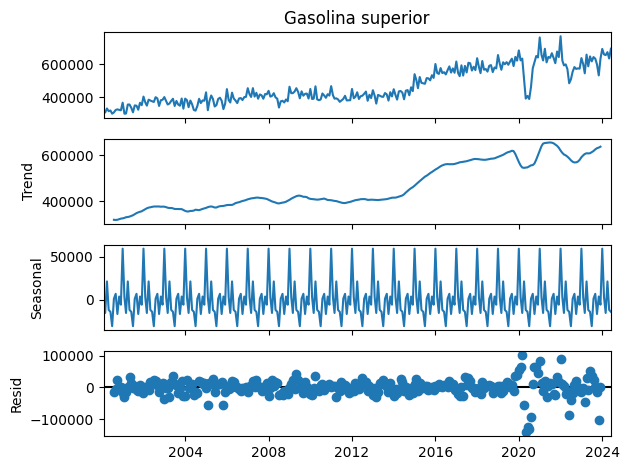

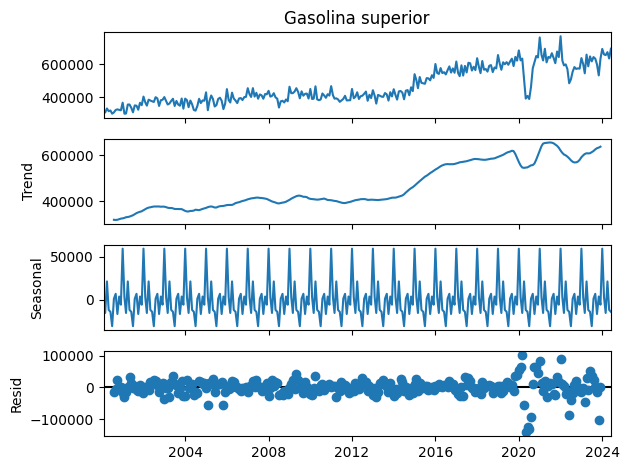

In [7]:
resultado_superiorC = seasonal_decompose(consumo_superior_resampled.dropna())
resultado_superiorC.plot()

### LSTM

In [8]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(consumo_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -0.678783
p-value                        0.852169
# de retardos usados          12.000000
# de observaciones usadas    280.000000
Critical Value (1%)           -3.453922
Critical Value (5%)           -2.871918
Critical Value (10%)          -2.572300
dtype: float64


In [9]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
consumo_diff = consumo_superior_resampled.diff()
consumo_diff.fillna(0,inplace=True)
dfTest = adfuller(consumo_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -4.675884
p-value                        0.000093
# de retardos usados          16.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


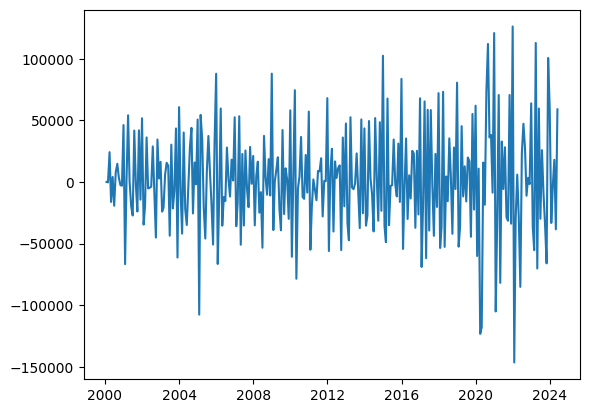

In [10]:
plt.plot(consumo_diff)

In [11]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
consumo_diff_array = consumo_diff.values

# Reshape a 2D
consumo_diff_array = consumo_diff_array.reshape(-1, 1)
data_c = scaler.fit_transform(consumo_diff_array)

In [12]:
entrenamiento = round(0.6*len(data_c))
val_prueba = round(0.2*len(data_c))
test = data_c[(entrenamiento+val_prueba)-1:]
validation = data_c[(entrenamiento):entrenamiento+val_prueba+1]
train = data_c[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

59

In [13]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

xC_train,yC_train = supervisada(train)
xC_val,yC_val = supervisada(validation)
xC_test,yC_test = supervisada(test)


In [14]:
xC_train = np.reshape(xC_train,(xC_train.shape[0],1,1))
xC_val = np.reshape(xC_val, (xC_val.shape[0],1,1))
xC_test = np.reshape(xC_test, (xC_test.shape[0],1,1))
len(xC_val)

59

In [15]:
modelo1 = Sequential()
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada
modelo1.add(LSTM(unidades, input_shape=(lote, caracteristicas), stateful=False))
modelo1.add(Dense(1))
modelo1.summary()

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [17]:
epocas = 50
history= modelo1.fit(
    x = xC_train,
    y = yC_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xC_val,yC_val),
    verbose=1
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.6625 - val_loss: 1.2165
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6336 - val_loss: 1.1636
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6114 - val_loss: 1.1216
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5939 - val_loss: 1.0884
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5800 - val_loss: 1.0622
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5689 - val_loss: 1.0416
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5601 - val_loss: 1.0256
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5531 - val_loss: 1.0131
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5476 - val_loss: 1.0029
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5430 - val_loss: 0.9937
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5386 - val_loss: 0.9846
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

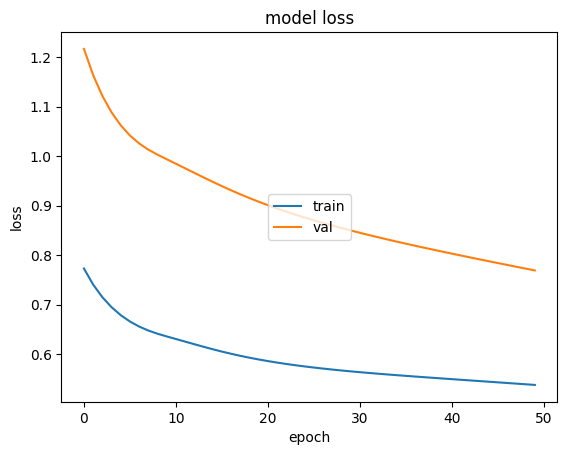

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [19]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = xC_train,
    y = yC_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = xC_val,
    y = yC_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = xC_test,
    y = yC_test
)

Pérdida en Entrenamiento
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5067  
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7854 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1812 


1.9945755004882812

In [20]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccionC_val = prediccion_fun(xC_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo_superior_resampled.values , n=entrenamiento)
prediccionC_test = prediccion_fun(xC_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = consumo_superior_resampled.values , n=entrenamiento+val_prueba)

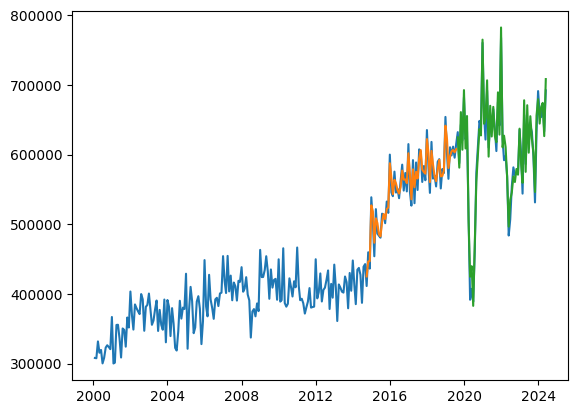

In [21]:
df_val = pd.DataFrame(prediccionC_val,index=consumo_superior_resampled[(entrenamiento):entrenamiento+val_prueba].index)
df_test = pd.DataFrame(prediccionC_test,index=consumo_superior_resampled[entrenamiento+len(df_val):len(consumo_superior_resampled)].index)


plt.plot(consumo_superior_resampled)
plt.plot(df_val)
plt.plot(df_test)



## Importacion


In [22]:
importacion["Gasolina superior"] = importacion["Gasolina superior"].astype(str)
importacion["Gasolina superior"] = importacion["Gasolina superior"].apply(lambda x: x.replace(',', '')).astype(float)
importacion.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
0,1-Jan,0,"27,748.99","214,581.84",0.0,0,0,0,"194,065.74",820,...,0.0,0,0,0,0.0,"566,101.99","8,402.00",0,"715,344.00","2,312,639.05"
1,1-Feb,0,"7,503.57","294,609.00",0.0,0,0,0,"170,703.38","3,054.00",...,0.0,0,0,0,0.0,"489,525.80",0,0,"370,166.00","1,769,208.76"
2,1-Mar,0,"26,304.32","315,263.80",0.0,0,0,0,"161,837.37",677,...,0.0,0,0,0,0.0,"575,559.68",0,0,"360,530.00","1,945,770.26"
3,1-Apr,0,"7,885.89","205,653.00",0.0,0,0,0,"163,048.64","3,399.00",...,0.0,0,0,0,0.0,"437,745.42","8,184.00",0,"359,527.00","1,623,637.76"
4,1-May,0,"8,443.16","278,371.30",0.0,0,0,0,"171,518.86",585,...,0.0,0,0,0,0.0,"552,609.13","12,680.00",0,"723,346.00","2,262,726.64"


In [23]:
importacion['Fecha'] = pd.to_datetime(importacion['Fecha'], format='%d-%b', errors='coerce')
importacion.set_index('Fecha', inplace=True)

### Series de tiempo

In [24]:
importacion_superior_resampled = importacion['Gasolina superior'].resample('M').mean()

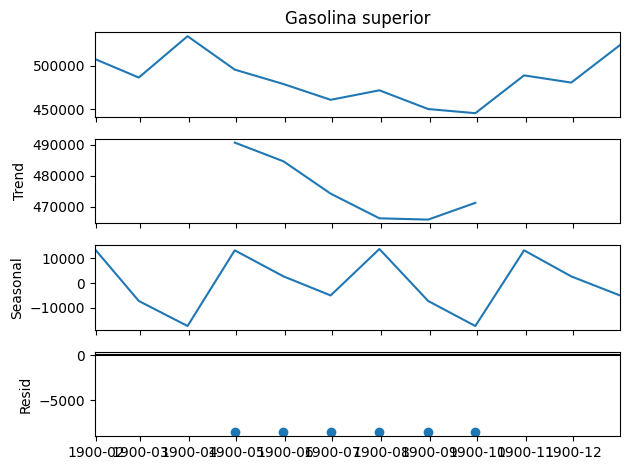

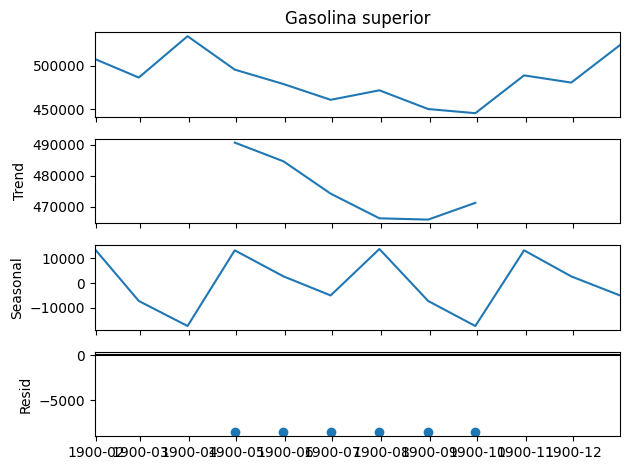

In [25]:
resultado_superior_i = seasonal_decompose(importacion_superior_resampled.dropna(), period=6)
resultado_superior_i.plot()

### LSTM

In [26]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(importacion_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -1.851236
p-value                       0.355337
# de retardos usados          0.000000
# de observaciones usadas    11.000000
Critical Value (1%)          -4.223238
Critical Value (5%)          -3.189369
Critical Value (10%)         -2.729839
dtype: float64


In [27]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
importacion_diff = importacion_superior_resampled.diff()
importacion_diff.fillna(0,inplace=True)
dfTest = adfuller(importacion_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -4.125597
p-value                       0.000878
# de retardos usados          0.000000
# de observaciones usadas    11.000000
Critical Value (1%)          -4.223238
Critical Value (5%)          -3.189369
Critical Value (10%)         -2.729839
dtype: float64


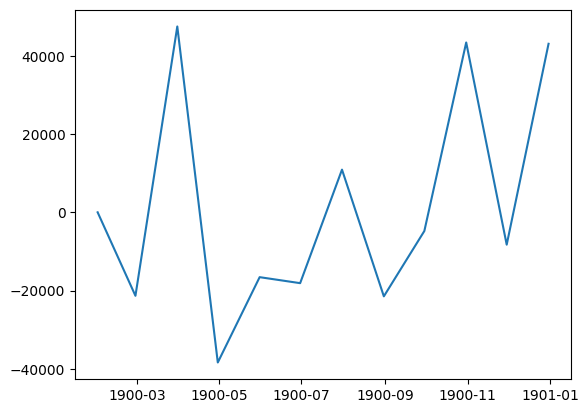

In [28]:
plt.plot(importacion_diff)

In [29]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
importacion_diff_array = importacion_diff.values

# Reshape a 2D
importacion_diff_array = importacion_diff_array.reshape(-1, 1)
data_i = scaler.fit_transform(importacion_diff_array)

In [30]:
entrenamiento_i = round(0.6*len(data_i))
val_prueba_i = round(0.2*len(data_i))
test = data_i[(entrenamiento_i+val_prueba_i)-1:]
validation = data_i[(entrenamiento_i):entrenamiento_i+val_prueba_i+1]
train = data_i[0:entrenamiento_i]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

4

In [31]:
xi_train,yi_train = supervisada(train)
xi_val,yi_val = supervisada(validation)
xi_test,yi_test = supervisada(test)


In [32]:
xi_train = np.reshape(xi_train,(xi_train.shape[0],1,1))
xi_val = np.reshape(xi_val, (xi_val.shape[0],1,1))
xi_test = np.reshape(xi_test, (xi_test.shape[0],1,1))
len(xi_val)

2

In [33]:
epocas = 50
history_i= modelo1.fit(
    x = xi_train,
    y = yi_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xi_val,yi_val),
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7236 - val_loss: 1.2004
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7217 - val_loss: 1.2040
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7200 - val_loss: 1.2075
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7184 - val_loss: 1.2110
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7170 - val_loss: 1.2144
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7155 - val_loss: 1.2179
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7142 - val_loss: 1.2213
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7128 - val_loss: 1.2247
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7115 - val_loss: 1.2281
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7103 - val_loss: 1.2314
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7090 - val_loss: 1.2348
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7078 - val_loss: 1.2381
Epoch

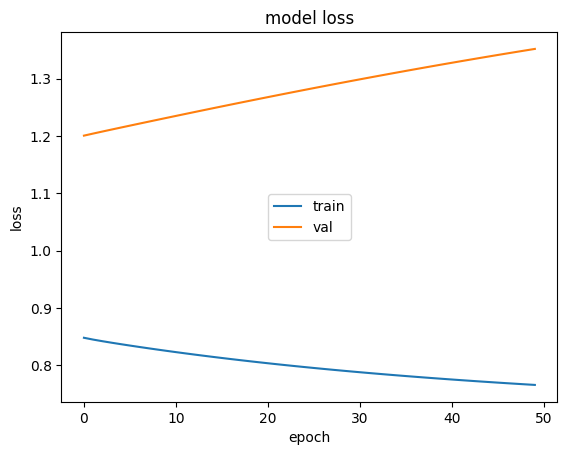

In [34]:
plt.plot(history_i.history['loss'])
plt.plot(history_i.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [35]:
prediccioni_val = []

prediccioni_val = prediccion_fun(xi_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series =importacion_superior_resampled.values , n=entrenamiento_i)
prediccioni_test = prediccion_fun(xi_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = importacion_superior_resampled.values , n=entrenamiento_i+val_prueba_i)

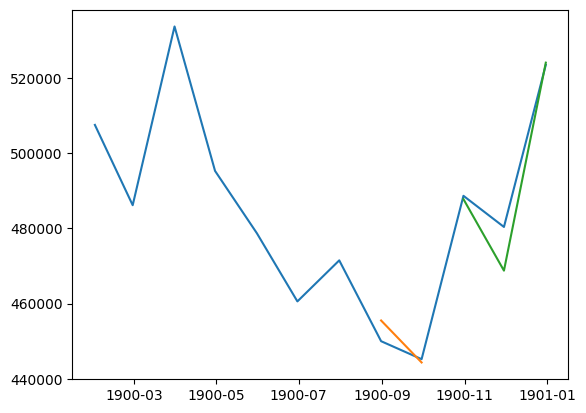

In [36]:
df_val_i = pd.DataFrame(prediccioni_val, index=importacion_superior_resampled[(entrenamiento_i):entrenamiento_i+val_prueba_i].index)
df_test_i = pd.DataFrame(prediccioni_test, index=importacion_superior_resampled[entrenamiento_i+len(df_val_i):len(importacion_superior_resampled)].index)


plt.plot(importacion_superior_resampled)
plt.plot(df_val_i)
plt.plot(df_test_i)


## Precios

In [37]:
PreciosPromedio.head()

,FECHA,Tipo de cambio,Superior,Regular,Diesel,Bunker,Glp Cilindro 25Lbs.,Unnamed: 7
0,1-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
1,2-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
2,3-Jan-21,7.79382,21.91,21.11,17.61,13.40,99.0,3.96
3,4-Jan-21,7.79417,21.91,21.11,17.61,13.45,99.0,3.96
4,5-Jan-21,7.79369,21.91,21.11,17.61,13.45,99.0,3.96


In [38]:
#PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], format='%d-%b-%Y', errors='coerce')
PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], errors='coerce')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15612\852106001.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  PreciosPromedio['FECHA'] = pd.to_datetime(PreciosPromedio['FECHA'], errors='coerce')


In [39]:
PreciosPromedio.set_index('FECHA', inplace=True)

### Serie de tiempo

In [40]:
precio_superior_resampled = PreciosPromedio['Superior'].resample('M').mean()

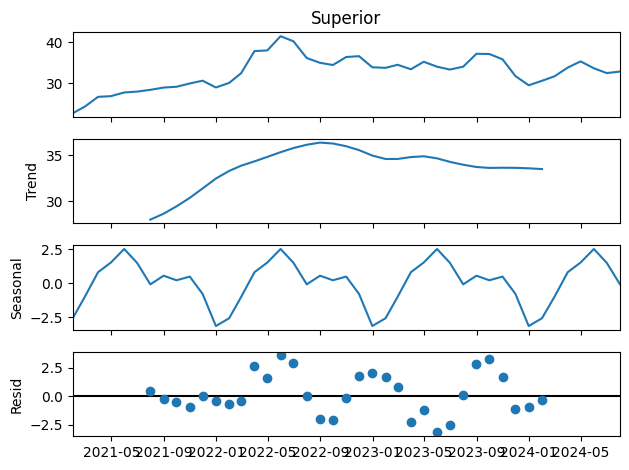

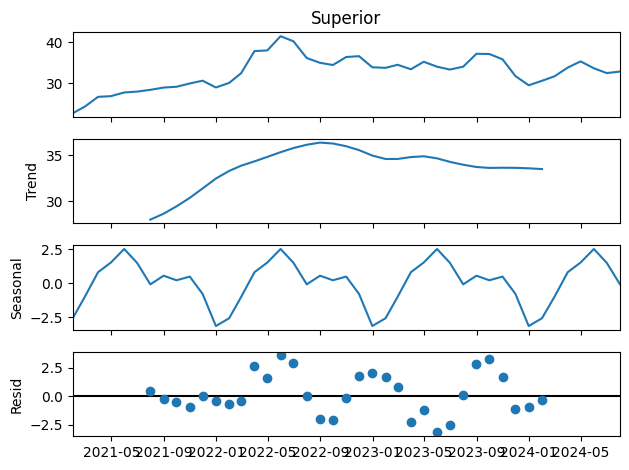

In [41]:
resultado_superiorP = seasonal_decompose(precio_superior_resampled.dropna())
resultado_superiorP.plot()


In [42]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(precio_superior_resampled, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba        -2.777253
p-value                       0.061597
# de retardos usados          1.000000
# de observaciones usadas    41.000000
Critical Value (1%)          -3.600983
Critical Value (5%)          -2.935135
Critical Value (10%)         -2.605963
dtype: float64


In [43]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
precio_diff = precio_superior_resampled.diff()
precio_diff.fillna(0,inplace=True)
dfTest = adfuller(precio_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba        -4.843615
p-value                       0.000045
# de retardos usados          0.000000
# de observaciones usadas    42.000000
Critical Value (1%)          -3.596636
Critical Value (5%)          -2.933297
Critical Value (10%)         -2.604991
dtype: float64


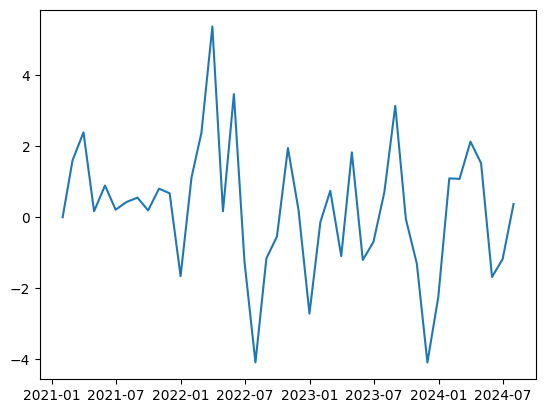

In [44]:
plt.plot(precio_diff)

In [45]:
scaler = StandardScaler()
# Convertir la serie a un array de NumPy
precio_diff_array = precio_diff.values

# Reshape a 2D
precio_diff_array = precio_diff_array.reshape(-1, 1)
data_p = scaler.fit_transform(precio_diff_array)

In [46]:
entrenamiento_p = round(0.6*len(data_p))
val_prueba_p = round(0.2*len(data_p))
test = data_p[(entrenamiento_p+val_prueba_p)-1:]
validation = data_p[(entrenamiento_p):entrenamiento_p+val_prueba_p+1]
train = data_p[0:entrenamiento_p]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

9

In [47]:
xp_train,yp_train = supervisada(train)
xp_val,yp_val = supervisada(validation)
xp_test,yp_test = supervisada(test)

In [48]:
xp_train = np.reshape(xp_train,(xp_train.shape[0],1,1))
xp_val = np.reshape(xp_val, (xp_val.shape[0],1,1))
xp_test = np.reshape(xp_test, (xp_test.shape[0],1,1))
len(xp_val)

9

In [49]:
epocas = 50
history_p= modelo1.fit(
    x = xp_train,
    y = yp_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (xp_val,yp_val),
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9296 - val_loss: 1.6636
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9181 - val_loss: 1.6642
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9084 - val_loss: 1.6648
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8991 - val_loss: 1.6653
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8901 - val_loss: 1.6658
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8815 - val_loss: 1.6662
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8732 - val_loss: 1.6666
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8652 - val_loss: 1.6669
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8575 - val_loss: 1.6672
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8501 - val_loss: 1.6674
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8429 - val_loss: 1.6676
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8360 - val_l

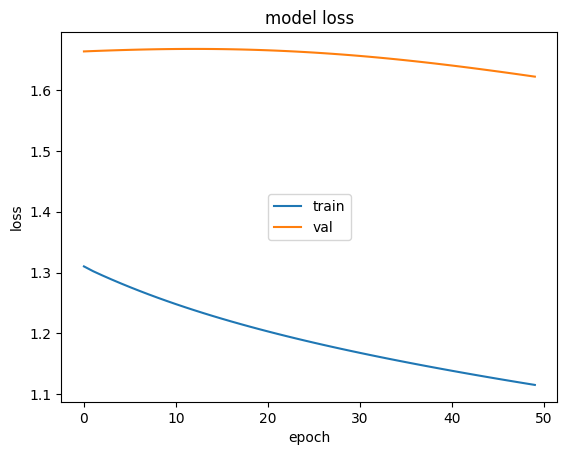

In [50]:
plt.plot(history_p.history['loss'])
plt.plot(history_p.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [51]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = xp_train,
    y = yp_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = xp_val,
    y = yp_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = xp_test,
    y = yp_test
)

Pérdida en Entrenamiento
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1120
Pérdida en Validación
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.6222
Pérdida en Prueba
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.8964


0.8963744640350342

In [52]:
prediccionp_val = []

prediccionp_val = prediccion_fun(xp_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series =precio_superior_resampled.values , n=entrenamiento_p)
prediccionp_test = prediccion_fun(xp_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = precio_superior_resampled.values , n=entrenamiento_p+val_prueba_p)

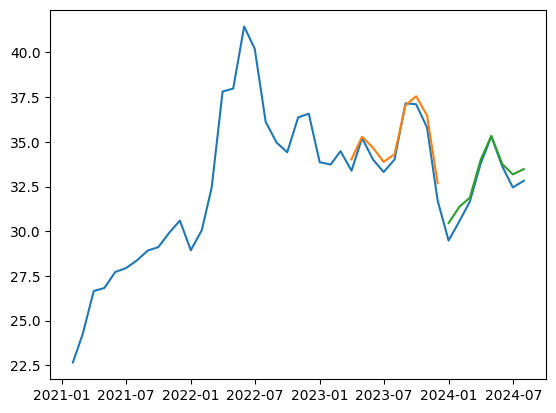

In [53]:
df_val_p = pd.DataFrame(prediccionp_val,index=precio_superior_resampled[(entrenamiento_p):entrenamiento_p+val_prueba_p].index)
df_test_p = pd.DataFrame(prediccionp_test,index=precio_superior_resampled[entrenamiento_p+len(df_val_p):len(precio_superior_resampled)].index)


plt.plot(precio_superior_resampled)
plt.plot(df_val_p)
plt.plot(df_test_p)


In [57]:
consumo = pd.read_csv('CONSUMO.csv')
importacion=pd.read_csv('IMPORTACION.csv')
PreciosPromedio=pd.read_csv('PreciosPromedio.csv')

# Mostrar los nombres de las columnas para verificar
print("Columnas en consumo_df:", consumo.columns)
print("Columnas en importacion_df:", importacion.columns)
print("Columnas en precios_df:", PreciosPromedio.columns)

Columnas en consumo_df: Index(['Fecha', 'Aceites lubricantes', 'Asfalto', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas\noleosas', 'Naftas',
       'PetCoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'Orimulsión', 'Total'],
      dtype='object')
Columnas en importacion_df: Index(['Fecha', 'Aceites lubricantes', 'Asfalto ', 'Bunker', 'Ceras',
       'Combustible turbo jet', 'Diesel bajo azufre',
       'Diesel ultra bajo azufre', 'Gas licuado de petróleo',
       'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
       'Grasas lubricantes', 'Kerosina', 'Mezclas oleosas', 'Naftas',
       'Petcoke', 'Petróleo crudo', 'Solventes', 'Butano',
       'Diesel alto azufre', 'MTBE', 'Orimulsión', 'Petróleo reconstituido',
       'Total importac

# Modelo 2

In [110]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [111]:
#Cargar los datos de nuevo
consumo = pd.read_csv('CONSUMO.csv')
importacion = pd.read_csv('IMPORTACION.csv')
PreciosPromedio = pd.read_csv('PreciosPromedio.csv')

In [112]:
#Función para limpiar los datos
def cleanData(df, column):
    df[column] = df[column].astype(str)  # Convertir a string
    df[column] = df[column].str.replace(',', '')  # Reemplazar comas
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convertir a numérico
    df.dropna(subset=[column], inplace=True)  # Eliminar filas con NaN
    return df

In [113]:
#Limpiar los datos
consumo = cleanData(consumo, 'Total')
importacion = cleanData(importacion, 'Total importación')
PreciosPromedio = cleanData(PreciosPromedio, 'Superior')

In [114]:
#Preprocesar los datos
scaler = MinMaxScaler(feature_range=(0, 1))

In [115]:
#Procesar cada serie
consumoData = consumo['Total'].values.reshape(-1, 1)
importacionData = importacion['Total importación'].values.reshape(-1, 1)
preciosPromedioData = PreciosPromedio['Superior'].values.reshape(-1, 1)

consumoScaled = scaler.fit_transform(consumoData)
importacionScaled = scaler.fit_transform(importacionData)
preciosPromedioScaled = scaler.fit_transform(preciosPromedioData)

In [116]:
#Dividir en conjuntos de entrenamiento y prueba
trainSize = int(len(consumoScaled) * 0.75)
testSize = len(consumoScaled) - trainSize
consumoTrain, consumo_test = consumoScaled[0:trainSize, :], consumoScaled[trainSize:len(consumoScaled), :]

trainSize = int(len(importacionScaled) * 0.75)
testSize = len(importacionScaled) - trainSize
importacionTrain, importacion_test = importacionScaled[0:trainSize, :], importacionScaled[trainSize:len(importacionScaled), :]

trainSize = int(len(preciosPromedioScaled) * 0.75)
testSize = len(preciosPromedioScaled) - trainSize
precioTrain, precio_test = preciosPromedioScaled[0:trainSize, :], preciosPromedioScaled[trainSize:len(preciosPromedioScaled), :]

In [117]:
#Función para crear conjuntos de datos para LSTM
def createDataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [118]:
#Crear conjuntos de datos para LSTM
timeStep = 10

X_train_con, y_train_con = createDataset(consumoTrain, timeStep)
X_test_con, y_test_con = createDataset(consumo_test, timeStep)

X_train_imp, y_train_imp = createDataset(importacionTrain, timeStep)
X_test_imp, y_test_imp = createDataset(importacion_test, timeStep)

X_train_pre, y_train_pre = createDataset(precioTrain, timeStep)
X_test_pre, y_test_pre = createDataset(precio_test, timeStep)

In [119]:
#Redimensionar la entrada para LSTM
X_train_con = X_train_con.reshape(X_train_con.shape[0], X_train_con.shape[1], 1)
X_test_con = X_test_con.reshape(X_test_con.shape[0], X_test_con.shape[1], 1)

X_train_imp = X_train_imp.reshape(X_train_imp.shape[0], X_train_imp.shape[1], 1)
X_test_imp = X_test_imp.reshape(X_test_imp.shape[0], X_test_imp.shape[1], 1)

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], X_train_pre.shape[1], 1)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], X_test_pre.shape[1], 1)

In [120]:
#Función para crear y compilar el modelo LSTM
def createLSTMmodel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(timeStep, 1)),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Creación y entrenamiento de los modelos

In [121]:
#Crear y entrenar los modelos
consumoModel = createLSTMmodel()
importacionModel = createLSTMmodel()
preciosPromedioModel = createLSTMmodel()

consumoModel.fit(X_train_con, y_train_con, batch_size=1, epochs=1)
importacionModel.fit(X_train_imp, y_train_imp, batch_size=1, epochs=1)
preciosPromedioModel.fit(X_train_pre, y_train_pre, batch_size=1, epochs=1)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0095
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0294
967/967 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0146


In [122]:
#Hacer predicciones con los modelos
train_predict_con = consumoModel.predict(X_train_con)
test_predict_con = consumoModel.predict(X_test_con)

train_predict_imp = importacionModel.predict(X_train_imp)
test_predict_imp = importacionModel.predict(X_test_imp)

train_predict_pre = preciosPromedioModel.predict(X_train_pre)
test_predict_pre = preciosPromedioModel.predict(X_test_pre)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [123]:
#Transformar de vuelta a la escala original
train_predict_con = scaler.inverse_transform(train_predict_con)
test_predict_con = scaler.inverse_transform(test_predict_con)

train_predict_imp = scaler.inverse_transform(train_predict_imp)
test_predict_imp = scaler.inverse_transform(test_predict_imp)

train_predict_pre = scaler.inverse_transform(train_predict_pre)
test_predict_pre = scaler.inverse_transform(test_predict_pre)

## Graficar resultados

In [124]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

### Consumo de Combustibles

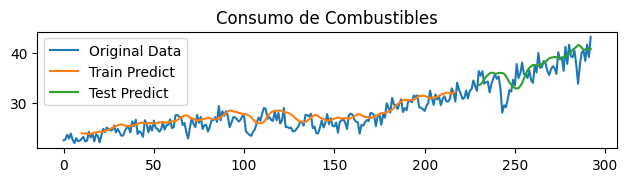

In [125]:
plt.subplot(3, 1, 1)
plt.plot(scaler.inverse_transform(consumoScaled), label='Original Data')
plt.plot(np.arange(timeStep, timeStep + len(train_predict_con)), train_predict_con, label='Train Predict')
plt.plot(np.arange(len(consumoScaled) - len(test_predict_con), len(consumoScaled)), test_predict_con, label='Test Predict')
plt.title('Consumo de Combustibles')
plt.legend()

plt.tight_layout()
plt.show()

### Importación de Combustibles

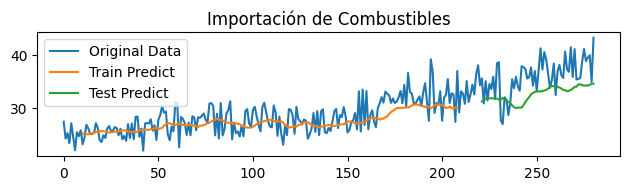

In [126]:
plt.subplot(3, 1, 2)
plt.plot(scaler.inverse_transform(importacionScaled), label='Original Data')
plt.plot(np.arange(timeStep, timeStep + len(train_predict_imp)), train_predict_imp, label='Train Predict')
plt.plot(np.arange(len(importacionScaled) - len(test_predict_imp), len(importacionScaled)), test_predict_imp, label='Test Predict')
plt.title('Importación de Combustibles')
plt.legend()

plt.tight_layout()
plt.show()

### Precios Promedios

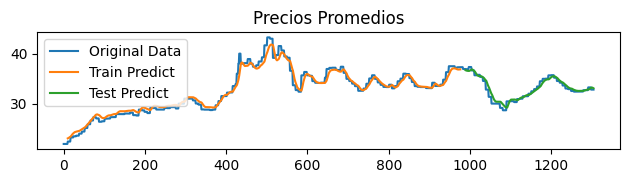

In [129]:
plt.subplot(3, 1, 3)
plt.plot(scaler.inverse_transform(preciosPromedioScaled), label='Original Data')
plt.plot(np.arange(timeStep, timeStep + len(train_predict_pre)), train_predict_pre, label='Train Predict')
plt.plot(np.arange(len(preciosPromedioScaled) - len(test_predict_pre), len(preciosPromedioScaled)), test_predict_pre, label='Test Predict')
plt.title('Precios Promedios')
plt.legend()

plt.tight_layout()
plt.show()

# Tuneo de parámetros

In [136]:
#Definir la función para crear el modelo con hiperparámetros variables
def createLSTMmodelHyperparameters(units=3, learning_rate=0.001):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units, return_sequences=True, input_shape=(time_step, 1)),
        tf.keras.layers.LSTM(units, return_sequences=False),
        tf.keras.layers.Dense(25),
        tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

#Función para ajustar un parámetro a la vez
def tuneSingleParam(X_train, y_train, X_val, y_val, param_name, param_values):
    best_loss = float('inf')
    best_value = None
    
    for value in param_values:
        print(f"Tuning {param_name} with value {value}")
        
        #Crear el modelo con el valor actual del parámetro
        if param_name == 'units':
            model = createLSTMmodelHyperparameters(units=value)
        elif param_name == 'learning_rate':
            model = createLSTMmodelHyperparameters(learning_rate=value)
        elif param_name == 'batch_size':
            model = createLSTMmodelHyperparameters()
        elif param_name == 'epochs':
            model = createLSTMmodelHyperparameters()

        #Entrenar el modelo
        if param_name in ['batch_size', 'epochs']:
            model.fit(X_train, y_train, batch_size=value if param_name == 'batch_size' else 16, epochs=value if param_name == 'epochs' else 3, verbose=0)
        else:
            model.fit(X_train, y_train, batch_size=16, epochs=3, verbose=0)
        
        #Evaluar el modelo
        loss = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation loss: {loss}")
        
        #Guardar el mejor parámetro
        if loss < best_loss:
            best_loss = loss
            best_value = value
    
    print(f"Best {param_name}: {best_value} with loss: {best_loss}")
    return best_value

#Separar un conjunto de validación
val_size = int(len(X_train_con) * 0.2)
X_val_con, y_val_con = X_train_con[-val_size:], y_train_con[-val_size:]
X_train_con, y_train_con = X_train_con[:-val_size], y_train_con[:-val_size]

X_val_imp, y_val_imp = X_train_imp[-val_size:], y_train_imp[-val_size:]
X_train_imp, y_train_imp = X_train_imp[:-val_size], y_train_imp[:-val_size]

X_val_pre, y_val_pre = X_train_pre[-val_size:], y_train_pre[-val_size:]
X_train_pre, y_train_pre = X_train_pre[:-val_size], y_train_pre[:-val_size]

#Ajustar los parámetros uno a la vez
best_units_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'units', [50, 100])
best_learning_rate_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'learning_rate', [0.001, 0.01])
best_batch_size_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'batch_size', [16, 32])
best_epochs_con = tuneSingleParam(X_train_con, y_train_con, X_val_con, y_val_con, 'epochs', [10, 50])

#Crear modelo con los mejores parámetros encontrados
model_con_tuned = createLSTMmodelHyperparameters(units=best_units_con, learning_rate=best_learning_rate_con)
model_con_tuned.fit(X_train_con, y_train_con, batch_size=best_batch_size_con, epochs=best_epochs_con, verbose=1)

#Repetir el proceso para los otros modelos
best_units_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'units', [50, 100])
best_learning_rate_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'learning_rate', [0.001, 0.01])
best_batch_size_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'batch_size', [16, 32])
best_epochs_imp = tuneSingleParam(X_train_imp, y_train_imp, X_val_imp, y_val_imp, 'epochs', [10, 50])

model_imp_tuned = createLSTMmodelHyperparameters(units=best_units_imp, learning_rate=best_learning_rate_imp)
model_imp_tuned.fit(X_train_imp, y_train_imp, batch_size=best_batch_size_imp, epochs=best_epochs_imp, verbose=1)

best_units_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'units', [50, 100])
best_learning_rate_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'learning_rate', [0.001, 0.01])
best_batch_size_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'batch_size', [16, 32])
best_epochs_pre = tuneSingleParam(X_train_pre, y_train_pre, X_val_pre, y_val_pre, 'epochs', [10, 50])

model_pre_tuned = createLSTMmodelHyperparameters(units=best_units_pre, learning_rate=best_learning_rate_pre)
model_pre_tuned.fit(X_train_pre, y_train_pre, batch_size=best_batch_size_pre, epochs=best_epochs_pre, verbose=1)


Tuning units with value 50
Validation loss: 0.004441237077116966
Tuning units with value 100
Validation loss: 0.005249352194368839
Best units: 50 with loss: 0.004441237077116966
Tuning learning_rate with value 0.001
Validation loss: 0.0059446366503834724
Tuning learning_rate with value 0.01
Validation loss: 0.004068940877914429
Best learning_rate: 0.01 with loss: 0.004068940877914429
Tuning batch_size with value 16
Validation loss: 0.004718521609902382
Tuning batch_size with value 32
Validation loss: 0.01640692539513111
Best batch_size: 16 with loss: 0.004718521609902382
Tuning epochs with value 10
Validation loss: 0.003955132327973843
Tuning epochs with value 50
Validation loss: 0.004780981689691544
Best epochs: 10 with loss: 0.003955132327973843
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0209
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0057
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 

# Comparación de los modelos entre ellos

El Modelo 1 tiene una arquitectura básica que incluye solo una capa LSTM con una unidad y mostró un rendimiento limitado. Aunque la pérdida en el conjunto de entrenamiento disminuyó consistentemente a lo largo de las 50 épocas, la pérdida en el conjunto de validación se mantuvo relativamente alta. Esto sugiere que el modelo tenía dificultades para capturar los patrones subyacentes en los datos, lo que podría indicar una tendencia al subajuste. El modelo no tenía la capacidad suficiente para aprender las complejidades presentes en las series de tiempo, especialmente en conjuntos de datos con fluctuaciones más pronunciadas, como la importación de combustibles y los precios.

Por otro lado, el Modelo 2 tiene una arquitectura que incluye dos capas LSTM con 50 unidades cada una y capas densas adicionales y mostró un rendimiento mucho mejor desde el principio. Incluso después de solo una época de entrenamiento, la pérdida en el conjunto de validación fue significativamente menor en comparación con el Modelo 1. Esto indica que el Modelo 2 fue capaz de generalizar mejor y capturar patrones más complejos en los datos, evitando tanto el subajuste como el sobreajuste, algo que se reflejó en las predicciones mucho más precisas en todos los conjuntos de datos.

En términos de precisión, el Modelo 2 superó ampliamente al Modelo 1, ya que las predicciones se acercaron mucho más a los valores reales en todas las series de tiempo analizadas. Por lo que en conclusión, el Modelo 2 es superior al Modelo 1 en términos de precisión y capacidad de generalización. Su arquitectura más compleja lo hace más adecuado para manejar series de tiempo con tendencias y variaciones significativas, lo que lo convierte en la opción preferida para tareas de pronóstico en los conjuntos de datos que se han analizado.